# 3D Convolutional autoencoder for voxel data!

 This code shows the example of a 3D convolution autoencoder applied on ModelNet40 and PSB datasets.
 It is the natural extension of [./2d_autoencoder.ipynb](Part 1) of this series.

 These links complement the ones introduced in Part 1:
 - https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/tree/master/Generative
 - https://github.com/AnTao97/PointCloudDatasets/blob/master/dataset.py

 ## Background
 This part of the series needs a bit more explaination. So far, there haven't been many attempts to use CNN's for 3D objects. Why? Probably because of the representation that would be required for a vanilla CNN to work without many changes.
 ### Pixels and Voxels
 The logical 3D extenstion of a 2D image would be a 3D grid, because an image is essentially a 2D grid with each cell representing a pixel. In the same manner 3D cells in a 3D grid are called voxels. In both cases, pixels and voxels are somewhat abstract containers that hold values. We typically think pixels strictly contain only color values but they can hold much more information. Opacity is an intuitive example, but we could even save meta-data in there. That was just for the intuition. Voxels are pretty common within neuroscience and obviously game technology.
 ### Voxels and Convolutions
 After this description it might be trivial, but we can extend the intuition about convolutions easily onto the next dimension. While we convolve for with a restricted set of 2D filters over images, we do the same with 3D objects. This time, we only imagine cubes instead of squares. In fact, many of you who have already used CNN's know, that this is already common practice, as we treat colors often as that third dimension. This flexibility ties back to the idea that these cells are merely containers and the dimensions can represent anything.
 ### So far so good... But what's the issue with those?
 Well, neither am I well acquainted with Game-Technology nor do I have a background in Computer Graphics. However, from what I understand, there are about X reasons:
 - First, voxel data is exponentially larger than pixel data, given the added dimension. Meaning, that you now need to deal with more data and all of it. If you just care about simple singular 3D models, most of the volume might be empty.
 - Second, depending on your resolution (which directly affects the data volume), things can become quite minecrafty.
 - Third, there are alternatives: Point clouds and polygons. Both are vector-based and the ladder even maintains structure.
 ### Why still use voxels then?
 They obviously also have advantages. They maintain structure, they are easy to process in computer graphics, they are great for procedural generation. Some of the algorythms for images like JPEG are easy to extend.
 ### Links
 For more about these matters checkout following materials:
 - [https://medium.com/@EightyLevel/how-voxels-became-the-next-big-thing-4eb9665cd13a](An explanation for voxels imminent comeback in Gaming. May be a bit difficult to follow.)
 - [https://www.quora.com/What-are-the-pros-and-cons-of-using-voxels-instead-of-polygons](Best explanation that I found on this topic. Also videogame centric.)

In [1]:
from datetime import datetime
from enum import auto
import functools
import io
from pyntcloud.structures.voxelgrid import VoxelGrid
import tensorflow as tf
import pickle
import pyvista as pv
from pyntcloud import PyntCloud
from tensorflow.python.keras.backend import dtype
from tensorflow.python.keras.engine.base_layer import Layer
from tqdm import tqdm
import pandas as pd
import glob
import random
import numpy as np
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import tensorflow.keras.optimizers as opt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import pathlib
from matplotlib.backends.backend_agg import FigureCanvasAgg

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.run_functions_eagerly(True)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

 I've defined a couple of functions that will be used below.
 Most of them only deal with plotting

In [8]:
def compose(f, g):
    return lambda arg: f(g(arg))


def retrieve_voxel_data(cloud, n=8):
    voxelgrid_id = cloud.add_structure("voxelgrid", n_x=n, n_y=n, n_z=n)
    voxelgrid = cloud.structures[voxelgrid_id]
    vol = np.array(voxelgrid.get_feature_vector(mode="binary"), dtype=np.uint16)
    return vol, voxelgrid


def plot_binary_pointcound(vertex_list):
    vertices = np.argwhere(vertex_list)
    tcloud = PyntCloud(pd.DataFrame(vertices, columns="x y z".split()))
    tcloud.plot(mesh=True, width=400, height=400, backend="threejs")


def generate_img_of_decodings(encodings, decodings, n=5, thresh=.8):
    rows = 2
    fig = plt.figure(figsize=(8, 5))

    for i in range(0, n):
        cnt = i + 1
        ax = fig.add_subplot(rows, n, cnt, projection='3d')
        elem1 = np.argwhere(encodings[i])
        ax.scatter(elem1[:, 0], elem1[:, 1], elem1[:, 2], cmap="Greys_r")
        # encoding_strings = "\n".join([f"{feature:.2f}" for feature in z[i]])
        ax = fig.add_subplot(rows, n, cnt + 1 * n, projection='3d')
        elem2 = np.argwhere(decodings[i] >= thresh)
        ax.scatter(elem2[:, 0], elem2[:, 1], elem2[:, 2], cmap="Greys_r")

    return fig


def generate_img_of_decodings_expanded(encodings, decodings, thresholds=[.9, .95, .99, .999, 1]):
    rows = 1
    fig = plt.figure(figsize=(25, 5))
    n = len(thresholds) + 1
    encoding_res = len(encodings[0])
    ax = fig.add_subplot(rows, n, 1, projection='3d')
    elem1 = np.argwhere(encodings[0])
    ax.set_title("Original")
    ax.scatter(elem1[:, 0], elem1[:, 1], elem1[:, 2], cmap="Greys_r")
    for i, tresh in enumerate(thresholds):
        cnt = i + 1
        ax = fig.add_subplot(rows, n, cnt + 1, projection='3d')
        ax.set_title(f"> {tresh:05.5f}")
        ax.set_xlim(0, encoding_res)
        ax.set_ylim(0, encoding_res)
        ax.set_zlim(0, encoding_res)
        mask = np.where(decodings[0] >= tresh, 1, np.zeros_like(decodings[0]))
        masked_elem = mask * decodings[0]
        elem2 = np.argwhere(masked_elem)
        ax.scatter(elem2[:, 0], elem2[:, 1], elem2[:, 2], cmap="Greys_r")

    return fig


def plot_pointcound(pynt_cloud_object, n=32):
    vol, example_voxelgrid = retrieve_voxel_data(pynt_cloud_object, n)
    return example_voxelgrid.plot(d=3, mode="binary", cmap="hsv", width=400, height=400)

def plot_pointcound_matplotlib(pynt_cloud_object, n=32):    
    vol, example_voxelgrid = retrieve_voxel_data(pynt_cloud_object, n)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  
    ax.voxels(vol)  
    return plt.show()




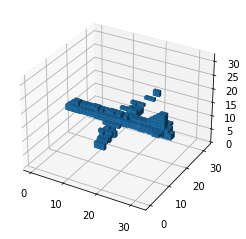

In [9]:
plot_pointcound_matplotlib(point_cloud_dataset_collected[4], 32)

 ## Data preprocessing
 Because I only have polygon meshes of the data, I decided to opt for a library to convert those to voxel representations.
 The library is called [https://github.com/daavoo/pyntcloud](pyntcloud).

In [3]:
path_to_dataset = pathlib.Path("data/dataset.pkl")
point_cloud_dataset_collected = None
num_meshes = None
if path_to_dataset.exists():
    point_cloud_dataset_collected = pickle.load(io.open(path_to_dataset, "rb"))
    num_meshes = len(point_cloud_dataset_collected)

if not path_to_dataset.exists():
    data_files = list(glob.glob(str("data/**/*.ply"), recursive=True))
    num_meshes = len(data_files)
    point_cloud_dataset_generator = (PyntCloud.from_file(mesh_file) for mesh_file in tqdm(data_files, total=num_meshes))
    point_cloud_dataset_collected = list(point_cloud_dataset_generator)
    pickle.dump(file=io.open(path_to_dataset, "wb"), obj=point_cloud_dataset_collected)
    print(f"Loaded point clouds for {num_meshes} meshes")

 Let's see what we got. I used 32 as a default cell count in all dimensions.
 32 is just an arbitrary number I chose. Obviously, the more the more fine grained the images but the more data to process.

In [6]:
plot_pointcound(point_cloud_dataset_collected[4], 32)

 Let's check out what we retrieve with a lower resolution

In [16]:
plot_pointcound(point_cloud_dataset_collected[4], 8)

 Now with a higher one

In [17]:
plot_pointcound(point_cloud_dataset_collected[4], 64)